# Ordinal Regression Tutorial

**Author:** Sam Zorowitz

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

--------
In this notebook, I will provide a brief tutorial on ordinal regression using Stan. Specifically, I will cover the generative model for ordinal data, varieties of link functions, and robust statistics. For more detailed tutorials, see [Kruschke (2014, Ch. 23)](https://www.elsevier.com/books/doing-bayesian-data-analysis/kruschke/978-0-12-405888-0), [Liddell & Kruschke (2018)](https://doi.org/10.1016/j.jesp.2018.08.009) and [Bürkner & Vuorre (2019)](https://doi.org/10.1177/2515245918823199).

--------

## Section 1: Ordinal Data

An ordinal variable is a special class of categorical variable where its levels have an inherent natural order. Examples of ordinal data in psychology are education levels, economic status, and Likert scale responses (e.g. "very satisfied", "satisfied", "dissatisfied", and "very dissatisfied"). 

Though ordinal variables share similarities with metric (continuous) and nomimal (categorical) variables, they cannot be correctly treated as either. As opposed to metric variables, the distance between two adjacent categories need not be linear. Though 1, 2, and 3 are evenly spaced on the number line, the psychological distance between the response categories 1, 2, and 3 on a Likert scale may not be the same. Moreover, metric variables (typically) do not show discontinuities whereas ordinal variables necessarily do. Though 3.14159 is a valid value of a metric variable, it is not for an ordinal variable representing a 5-point Likert scale. 

Ordinal and nominal variables are similar insofar both are described by categories. What sets of ordinal variables apart is that the categories have an inherent order and we want our models to reflect as such. In contrast to classification models, we want ordinal models to assign greater penalties for predicting Level 1 than Level 2 when the observed response was Level 3. 

#### 1.1 Generative Model

So, how do we model ordinal data? For the sake of demonstration, assume we've administered a single-item survey of ice cream preferences ("How much do you like vanilla ice cream?") to 40 participants. The response options were "Not at all", "A little", "Somewhat", and "A lot", which were coded 1, 2, 3, and 4 respectively.

To model the observed the ordinal preference rating, $Y$, we assume a participant's response originates from the categorization of a latent (unobservable) continuous variable, $\hat{Y}$. As we will see below, this latent variable can be a function of observable inputs (as in regression) or other unobservable latent variables particular to the respondent. For the time being, we will assume the latent variable is distributed according to the standard normal distribution.

In order to map the latent variable to the observed ordinal variable, we need to introduce two components. First, we need a set of threshold variables, $\tau$, which partition the range of $\hat{Y}$ into the categories of $Y$. Second, we need to define a cumulative distribution function, $F$, which when combined with the thresholds allows us to calculate the probability of observing a response, $Y$, given the latent variable, $\hat{Y}$.

To make this concrete, let us visualize an example ordinal model for our ice cream survey. Because there are four response categories, we need 3 thresholds to partition the space. We will define these as [-1.5, 0.0, 1.5]. For our cumulative link function, we will use the CDF of the standard normal, $\Phi$, also known as the probit function. 

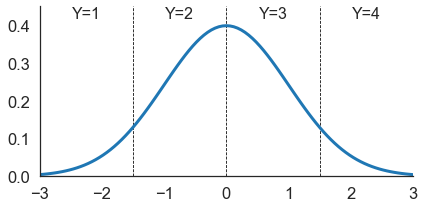

In [2]:
from scipy.stats import norm

## Define thresholds.
tau = [-1.5, 0, 1.5]

## Define latent space.
x = np.linspace(-3,3,101)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Plot.
ax.plot(x, norm.pdf(x), lw=3)
ax.vlines(tau, 0, 0.45, lw=0.8, linestyle='--')
ax.set(xlim=(-3,3), ylim=(0,0.45))
ax.text(-2.25,0.45,'Y=1',ha='center',va='top',fontsize=16)
ax.text(-0.75,0.45,'Y=2',ha='center',va='top',fontsize=16)
ax.text( 0.75,0.45,'Y=3',ha='center',va='top',fontsize=16)
ax.text( 2.25,0.45,'Y=4',ha='center',va='top',fontsize=16)

sns.despine()
plt.tight_layout()

From the link function and set of thresholds above, one might expect that responses of 2 and 3 would be more common than responses of 1 and 4. This suspicion is correct, and we can verify this as the probability of a response can be computed as:

$$ p(Y = k) = F(\tau_k) - F(\tau_{k-1}) $$ 

At the extreme anchors, this simplifies to:

$$ p(Y = 1) = F(\tau_{1}) $$ 

and where $u$ is the maximum response:

$$ p(Y = u) = 1 - F(\tau_{u-1}) $$ 

We can now compute the response probabilities from the example above:

In [3]:
## Preallocate space.
p = np.zeros(4)

## Compute probabilities.
p[0] = norm.cdf(tau[0])
p[1] = norm.cdf(tau[1]) - norm.cdf(tau[0])
p[2] = norm.cdf(tau[2]) - norm.cdf(tau[1])
p[3] = 1 - norm.cdf(tau[2])

print(p.round(3))

[0.067 0.433 0.433 0.067]


As we can see, given the parameterization above, the extreme responses, 1 and 4, are less likely to be observed than the middling responses. We would expect different distributions of responses for different threshold parameterizations. For example, if we decrease the distance of the outer two thresholds from the center:

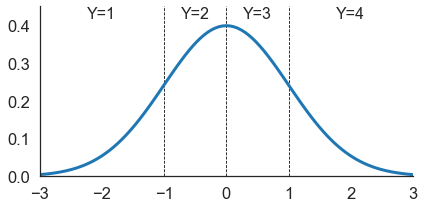

In [4]:
from scipy.stats import norm

## Define thresholds.
tau = [-1, 0, 1]

## Define latent space.
x = np.linspace(-3,3,101)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Plot.
ax.plot(x, norm.pdf(x), lw=3)
ax.vlines(tau, 0, 0.45, lw=0.8, linestyle='--')
ax.set(xlim=(-3,3), ylim=(0,0.45))
ax.text(-2.00,0.45,'Y=1',ha='center',va='top',fontsize=16)
ax.text(-0.50,0.45,'Y=2',ha='center',va='top',fontsize=16)
ax.text( 0.50,0.45,'Y=3',ha='center',va='top',fontsize=16)
ax.text( 2.00,0.45,'Y=4',ha='center',va='top',fontsize=16)

sns.despine()
plt.tight_layout()

As compared to before, more probability mass is assigned to the more extreme responses. We can verify this:

In [5]:
## Preallocate space.

## Preallocate space.
p = np.zeros(4)

## Compute probabilities.
p[0] = norm.cdf(tau[0])
p[1] = norm.cdf(tau[1]) - norm.cdf(tau[0])
p[2] = norm.cdf(tau[2]) - norm.cdf(tau[1])
p[3] = 1 - norm.cdf(tau[2])

print(p.round(3))

[0.159 0.341 0.341 0.159]


We should be clear in saying that the thresholds do not represent features of the distribution of the latent variable. The thresholds describe the mapping between the latent distribution and observed ordinal responses. It should also be noted that there exist isomorphic forms of the ordinal model. Here we are assigning response probabilities via changing thresholds, but this is not the only way to do so. For example, one can hold fixed the interval between thresholds and define an ordinal model as the position of the first threshold and the interval length. Different parameterizations may allow for slightly different flexibility, but often times will yield similar (if not identical) results.

#### 1.2 Link Functions

As noted above, the cumulative distribution (link) function provides the mapping between the partitioned latent space and probabilities. The two most common link functions for ordinal regression the cumulative normal (probit) function, as shown above, and the logistic (logit) function. Though they have slightly different shapes, they will provide largely similar model fits when thresholds are allowed to vary. 

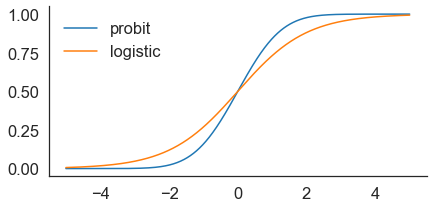

In [6]:
from scipy.stats import norm, cauchy, t

def logistic(arr):
    return 1. / (1 + np.exp(-arr))

## Define latent space.
x = np.linspace(-5,5,1001)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Plot functions.
ax.plot(x, norm.cdf(x), label='probit')
ax.plot(x, logistic(x), label='logistic')

ax.legend(loc=2, frameon=False)

sns.despine()
plt.tight_layout()

#### 1.3 Ordinal Regression

So far we have only discussed the link between the observed respones and unobserved latent variable. To perform ordinal regression, we must define how the predictor variables are integrated. Simply put, we define the latent variable as:

$$ \hat{Y} = \mu = X \cdot \beta $$

where $X$ is a row vector of independent variables and $\beta$ is a vector of regression coefficients. Then, the likelihood of a response is simply:

$$ p(Y = k) = F(\tau_k - \mu) - F(\tau_{k-1} - \mu) $$ 

#### 1.4 Complete Example

In [7]:
import pystan

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Sampling parameters.
samples = 2500
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Define metadata.
N = 40
K = 2
U = 4

## Define generative model.
tau = [-0.75, 0, 0.75]
rho = 0.9

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define latent covariance matrix.
Sigma = [[1,rho],[rho,1]]

## Simulate data.
zscore = lambda arr: (arr - arr.mean()) / arr.std()
x, y = np.random.multivariate_normal(np.zeros(2), Sigma, N).T

## Normalize data.
x = zscore(x); y = zscore(y)

## Make design matrix.
X = np.column_stack([np.ones_like(x),x])

## Make response probabilities.
theta = norm.cdf(np.subtract.outer(np.array(tau), y)).T
theta = np.column_stack([np.zeros(N), theta, np.ones(N)])
theta = np.diff(theta, axis=1)

## Make observed responses. 
f = lambda p: np.argmax(np.random.multinomial(1, p))
Y = np.apply_along_axis(f, 1, theta) + 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model w/ Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(N=N, K=K, U=U, Y=Y, X=X)

## Compile model.
StanModel = pystan.StanModel(file='ordinal_probit.stan')

## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, 
                             thin=thin, n_jobs=n_jobs, seed=47404)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_94383477bd0c7c46cfc7acef21288255 NOW.


## Section 2: Robust Ordinal Regression

There are link functions beyond the probit and logistic functions (for a review, see [Koenker & Yoon, 2009](https://doi.org/10.1016/j.jeconom.2009.01.009) and [Smith et al., 2020](https://digitalcommons.wayne.edu/jmasm/vol18/iss1/20/)). We review several below.

#### 2.1 Symmetric heavy-tailed links

Heavier-tailed link functions are suggested for high kurtosis response distributions. Example link functions include the Student-T (robit) and Cauchy (cauchit) link functions. The robit and cauchit link functions are also suggested for robust ordinal regression in the face of noise ([Liu et al. 2004](https://doi.org/10.1002/0470090456.ch21), [Kim et al. 2008](https://doi.org/10.1093/biomet/asm079)).

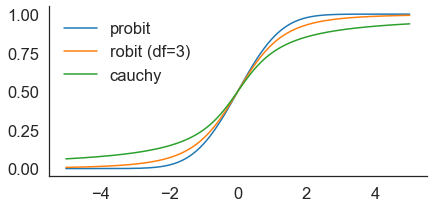

In [8]:
from scipy.stats import norm, cauchy, t

def cauchit(arr):
    return cauchy(0,1).cdf(arr)

def student_t(arr,df=5):
    return t(df, 0, 1).cdf(arr)

def cloglog(arr):
    return 1. - np.exp(-np.exp(arr))

def loglog(arr):
    return np.exp(-np.exp(-arr)) 

## Define latent space.
x = np.linspace(-5,5,1001)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Plot functions.
ax.plot(x, norm.cdf(x), label='probit')
ax.plot(x, t.cdf(x,df=3), label='robit (df=3)')
ax.plot(x, cauchy.cdf(x), label='cauchy')

ax.legend(loc=2, frameon=False)

sns.despine()
plt.tight_layout()

#### 2.2 Asymmetric links

Asymmetric links are suggested in the case of asymmetric response distributions ([Smith et al., 2020](https://digitalcommons.wayne.edu/jmasm/vol18/iss1/20/)). Example link functions include the log-log and complementary log-log links.

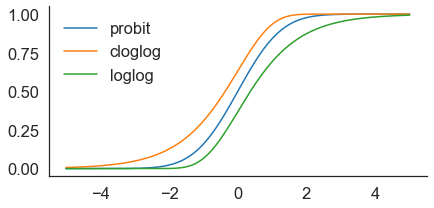

In [9]:
def cloglog(arr):
    return 1. - np.exp(-np.exp(arr))

def loglog(arr):
    return np.exp(-np.exp(-arr)) 

## Define latent space.
x = np.linspace(-5,5,1001)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Plot functions.
ax.plot(x, norm.cdf(x), label='probit')
ax.plot(x, cloglog(x), label='cloglog')
ax.plot(x, loglog(x), label='loglog')

ax.legend(loc=2, frameon=False)

sns.despine()
plt.tight_layout()

### 2.3 Complete Example

In the example below, we show how the presence of only a few outliers can substantially supress ordinal regression effects when using the probit link. The cauchit link is robust to outliers. This example was inspired by [Baez-Ortega (2018)](https://baezortega.github.io/2018/05/28/robust-correlation/).

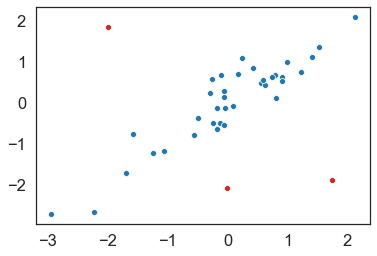

In [10]:
import pystan

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Sampling parameters.
samples = 2500
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Define metadata.
N = 40
K = 2
U = 4

## Define generative model.
tau = [-0.75, 0, 0.75]
rho = 0.9

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define latent covariance matrix.
Sigma = [[1,rho],[rho,1]]

## Simulate data.
zscore = lambda arr: (arr - arr.mean()) / arr.std()
x, y = np.random.multivariate_normal(np.zeros(2), Sigma, N).T

## Normalize data.
x = zscore(x); y = zscore(y)

## Insert outliers.
x = np.append(x[:-3], [1.75, 0, -2])
y = np.append(y[:-3], [-1.9, -2.1, 1.85])

## Make design matrix.
X = np.column_stack([np.ones_like(x),x])

## Make response probabilities.
theta = norm.cdf(np.subtract.outer(np.array(tau), y)).T
theta = np.column_stack([np.zeros(N), theta, np.ones(N)])
theta = np.diff(theta, axis=1)

## Make observed responses. 
f = lambda p: np.argmax(np.random.multinomial(1, p))
Y = np.apply_along_axis(f, 1, theta) + 1

sns.scatterplot(x[:-3], y[:-3], color='#1f77b4')
sns.scatterplot(x[-3:], y[-3:], color='#d62728')

Fit model with probit (non-robust) link.

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model w/ Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(N=N, K=K, U=U, Y=Y, X=X)

## Compile model.
StanModel = pystan.StanModel(file='ordinal_probit.stan')

## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, 
                             thin=thin, n_jobs=n_jobs, seed=47404)

print(StanFit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_94383477bd0c7c46cfc7acef21288255 NOW.


Inference for Stan model: anon_model_94383477bd0c7c46cfc7acef21288255.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]    -0.12    0.02   0.71  -1.54   -0.6  -0.11   0.34   1.35   1035    1.0
beta[2]     0.52  4.4e-3   0.17   0.18   0.41   0.52   0.63   0.86   1573    1.0
tau_pr[1]   -1.0    0.02   0.71  -2.41  -1.47  -0.98  -0.55   0.48   1020    1.0
tau_pr[2]  -0.54  8.7e-3   0.32  -1.24  -0.74  -0.51  -0.31   0.02   1347    1.0
tau_pr[3]  -0.34  7.6e-3   0.28  -0.93  -0.53  -0.33  -0.15   0.17   1383    1.0
tau[1]      -1.0    0.02   0.71  -2.41  -1.47  -0.98  -0.55   0.48   1020    1.0
tau[2]     -0.39    0.02   0.72  -1.82  -0.85  -0.38   0.07   1.06   1007    1.0
tau[3]      0.35    0.02   0.73   -1.1  -0.12   0.36   0.82   1.87   1053    1.0
lp__      -52.73    0.06   1.64 -56.91 -53.53 -52.34 -51.57 -50.61    854    1.0

S

Fit model with cauchity (robust) link.

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model w/ Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(N=N, K=K, U=U, Y=Y, X=X)

## Compile model.
StanModel = pystan.StanModel(file='ordinal_cauchit.stan')

## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, 
                             thin=thin, n_jobs=n_jobs, seed=47404)

print(StanFit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ff5786124188e4b785663ecdc3f504ec NOW.


Inference for Stan model: anon_model_ff5786124188e4b785663ecdc3f504ec.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]     0.31    0.02   0.71  -1.11  -0.18   0.33   0.79   1.68   1224    1.0
beta[2]     1.19    0.02   0.42   0.42    0.9   1.16   1.45   2.13    548   1.02
tau_pr[1]  -1.44    0.02   0.73  -2.89  -1.91  -1.43  -0.97  -0.03   1129    1.0
tau_pr[2]   0.17    0.01   0.38  -0.66  -0.07   0.17   0.43   0.89   1408    1.0
tau_pr[3]   0.21  9.5e-3   0.32  -0.45 5.2e-3   0.22   0.44   0.79   1148   1.01
tau[1]     -1.44    0.02   0.73  -2.89  -1.91  -1.43  -0.97  -0.03   1129    1.0
tau[2]     -0.17    0.02   0.71  -1.59  -0.64  -0.19   0.32   1.29   1263    1.0
tau[3]      1.13    0.02    0.8  -0.49   0.58   1.14   1.67   2.71   1244    1.0
lp__      -50.56    0.06   1.67 -54.63 -51.41  -50.2 -49.34  -48.3    765    1.0

S